In [1]:
# 🔧 Install required packages (run this cell only once)
!pip install torch torchvision matplotlib scikit-learn opencv-python --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.1 MB/s eta 0:00:00


In [23]:
import zipfile
import os

# Replace with your actual zip filename
zip_file = 'archive.zip'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('unzipped')

# Set path to training folder
train_dir = 'unzipped/Forest Fire Dataset/Training'

# Check fire and nofire folders
print("🔥 Fire images:", len(os.listdir(os.path.join(train_dir, 'fire'))))
print("🌿 No Fire images:", len(os.listdir(os.path.join(train_dir, 'nofire'))))


🔥 Fire images: 760
🌿 No Fire images: 760


In [25]:
# 📦 Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [26]:
data_dir = 'unzipped/Forest Fire Dataset/Training'

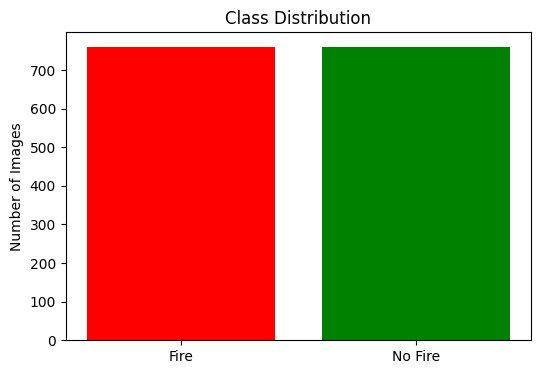

In [27]:
import matplotlib.pyplot as plt

fire_count = len(os.listdir(os.path.join(train_dir, 'fire')))
nofire_count = len(os.listdir(os.path.join(train_dir, 'nofire')))

plt.figure(figsize=(6, 4))
plt.bar(['Fire', 'No Fire'], [fire_count, nofire_count], color=['red', 'green'])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()


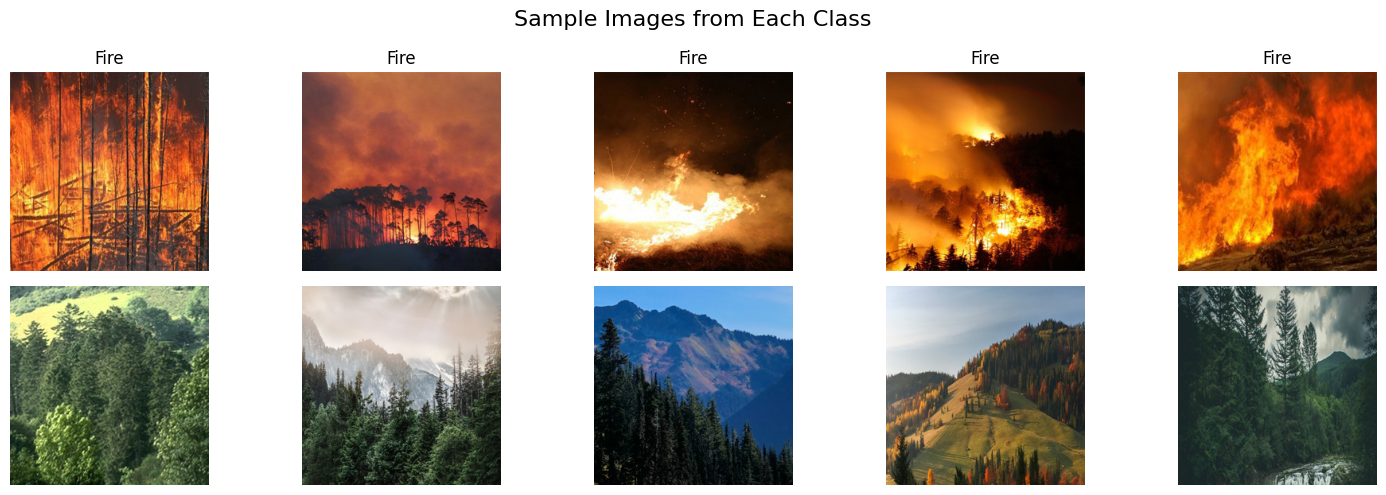

In [15]:
import random
from PIL import Image

def plot_samples_from_each_class(class_dirs, num_images=5):
    fig, axs = plt.subplots(2, num_images, figsize=(15, 5))
    for i, cls in enumerate(class_dirs):
        class_path = os.path.join(train_dir, cls)
        images = random.sample(os.listdir(class_path), num_images)
        for j, img_name in enumerate(images):
            img = Image.open(os.path.join(class_path, img_name))
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if i == 0:
                axs[i, j].set_title(f"{cls.capitalize()}")
    plt.suptitle("Sample Images from Each Class", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_samples_from_each_class(['fire', 'nofire'])


In [6]:
# 🧠 Feature Engineering (custom transform function)
# We apply Gaussian blur (noise reduction) and convert images to HSV color space
import torchvision.transforms.functional as TF
from PIL import Image

class CustomTransform:
    def __init__(self):
        self.resize = transforms.Resize((224, 224))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                              [0.229, 0.224, 0.225])

    def __call__(self, img):
        # Convert to OpenCV format
        img_cv = np.array(img)
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2HSV)  # Color space transform
        img_cv = cv2.GaussianBlur(img_cv, (3, 3), 0)       # Noise reduction
        img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_HSV2RGB))  # Back to PIL

        img_resized = self.resize(img_pil)
        img_tensor = self.to_tensor(img_resized)
        return self.normalize(img_tensor)


In [7]:
# 📚 Load dataset with transforms
transform = CustomTransform()
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes


In [8]:
# ⚙️ Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


In [20]:
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/4], Loss: 0.0005
Epoch [2/4], Loss: 0.0004
Epoch [3/4], Loss: 0.0010
Epoch [4/4], Loss: 0.0039


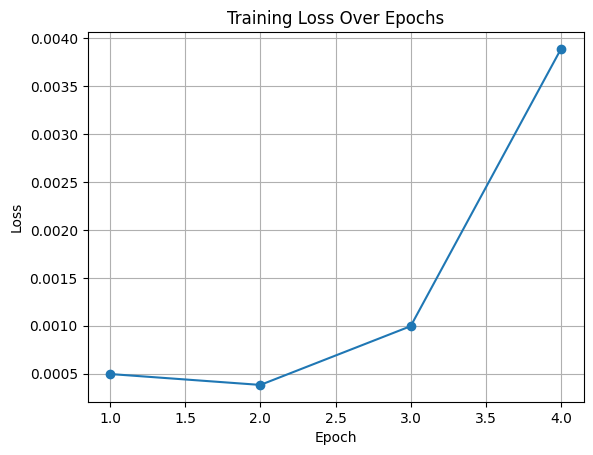

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [22]:
# 📈 Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.cpu().tolist())
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

        fire       1.00      0.99      0.99       150
      nofire       0.99      1.00      0.99       154

    accuracy                           0.99       304
   macro avg       0.99      0.99      0.99       304
weighted avg       0.99      0.99      0.99       304



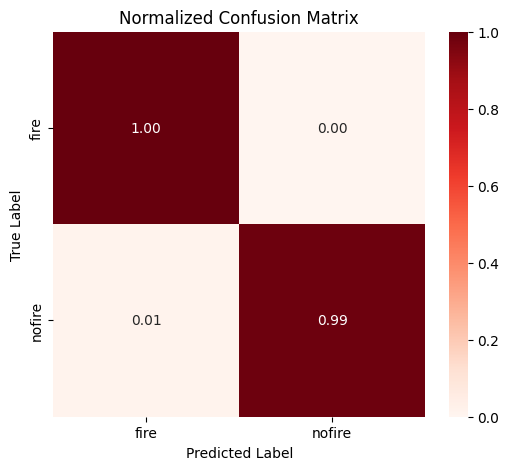

In [18]:
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


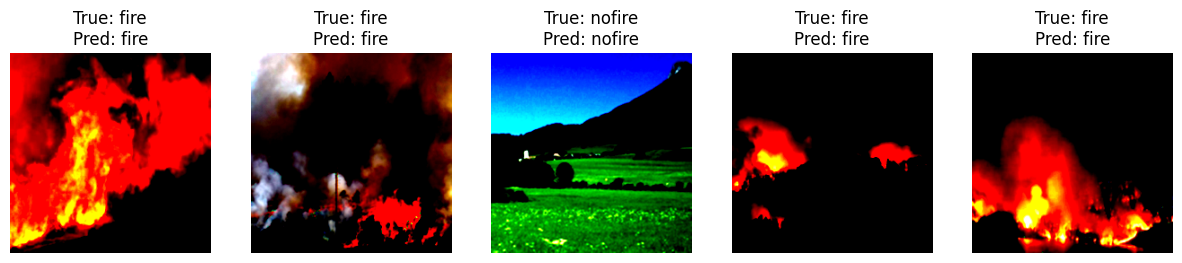

In [11]:
# 🔍 Predict on a few validation images
def show_predictions(model, dataset, num_images=5):
    model.eval()
    fig, ax = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img, label = dataset[i]
        input_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
        ax[i].imshow(img.permute(1, 2, 0).cpu().numpy())
        ax[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred.item()]}")
        ax[i].axis('off')
    plt.show()

show_predictions(model, val_dataset)


In [12]:
# 💾 Save the trained model
torch.save(model.state_dict(), 'forest_fire_detector.pth')
print("✅ Model saved as 'forest_fire_detector.pth'")


✅ Model saved as 'forest_fire_detector.pth'
